### Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.  
$$lrate=d_{model}^{-0.5}*min(\text{step_num}^{-0.5}, \text{step_num}*\text{warmup_steps}^{-1.5})$$

显然是先递增后递减，间断点：
$$\text{step_num}^{-0.5} = \text{step_num}*\text{warmup_steps}^{-1.5}$$
$$step = \text{ward_step}$$


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [3]:
# 自定义的 learning
learning_rate = CustomSchedule(d_model=512)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

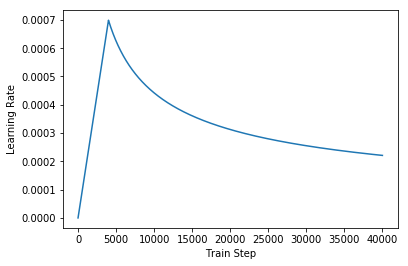

In [4]:
temp_learning_rate_schedule = CustomSchedule(d_model=512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### loss

In [8]:
tf.__version__

'2.0.0-dev20190508'

### tf.keras.losses.CategoricalCrossentropy()

```python
__call__(
    y_true,
    y_pred,
    sample_weight=None
)
```

In [12]:
cce = tf.keras.losses.CategoricalCrossentropy(reduction='none')
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]])
print('Loss: ', loss.numpy())  # Loss: 0.3239

Loss:  [0.10536055 0.8046684  0.06187541]


### tf.keras.losses.SparseCategoricalCrossentropy

和 CategoricalCrossentropy 一样都是属于多分类，但是 Sparse 对应的 y_pred 是[batch],而后者是 [batch, num_classes].


In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [17]:
y_true = tf.convert_to_tensor([0,1,2], dtype=tf.float32)
y_pred = tf.convert_to_tensor([[.9, .05, .05], [.5, .89, .6], [.05, .01, .94]], dtype=tf.float32)

In [19]:
loss_ = loss_object(y_true, y_pred)
loss_

<tf.Tensor: id=153, shape=(3,), dtype=float32, numpy=array([0.6177929 , 0.88596374, 0.59067667], dtype=float32)>

In [23]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    score = X.dot(W)  ##(N,3073)*(3073,10) = (N,10)
    score -= np.max(score, axis=1, keepdims=True)  # [N,10]
    exp_score = np.exp(score)  # [N,10]
    sum_score = np.sum(exp_score, axis=1, keepdims=True)  # numpy 广播机制，很关键！
    coef = exp_score / sum_score
    loss = np.sum(-np.log(coef[range(num_train), y]))
    loss /= num_train
    loss += reg * np.sum(W * W)

    coef_yi = np.zeros_like(coef)
    coef_yi[range(num_train), y] = 1
    dW = X.T.dot(coef - coef_yi)
    dW /= num_train
    dW += reg * 2 * W
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

In [24]:
def loss_function(real, pred):
    # 这里 real 是 target sentence 的 index，这里实际计算的就是 padding mask，也就是不考虑 padding 词的loss
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### metric

In [25]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
m = tf.keras.metrics.SparseCategoricalCrossentropy()
m.update_state([1, 2], [[0.05, 0.95, 0], [0.1, 0.8, 0.1]])

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2.0>